In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time

In [2]:
grid_size = 100
num_obstacles = 200  
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate
epsilon = 0.1  # Exploration factor for Q-learning
episodes = 500  # Number of episodes to train for Q-Learning and SARSA

In [3]:
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

In [4]:
class GridWorld:
    def __init__(self, size, num_obstacles):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (np.random.randint(size), np.random.randint(size))
        self.goal = (np.random.randint(size), np.random.randint(size))
        
        while self.goal == self.start:
            self.goal = (np.random.randint(size), np.random.randint(size))
        
        self.obstacles = set()
        for _ in range(num_obstacles):
            obstacle = (np.random.randint(size), np.random.randint(size))
            if obstacle != self.start and obstacle != self.goal:
                self.obstacles.add(obstacle)
        
        for obs in self.obstacles:
            self.grid[obs] = -1  

    def is_valid(self, state):
        x, y = state
        return 0 <= x < self.size and 0 <= y < self.size and (x, y) not in self.obstacles

    def reward(self, state):
        if state == self.goal:
            return 10
        elif state in self.obstacles:
            return -5
        return -0.1

    def step(self, state, action):
        new_state = (state[0] + action[0], state[1] + action[1])
        if not self.is_valid(new_state):
            return state, self.reward(state)  
        return new_state, self.reward(new_state)

In [5]:
class QLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(actions)
        action_idx = np.argmax(self.q_table[state])
        return actions[action_idx]

    def update_q_value(self, state, action, reward, next_state):
        action_idx = actions.index(action)
        best_next_action = np.max(self.q_table[next_state])
        td_target = reward + self.gamma * best_next_action
        td_delta = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.alpha * td_delta

    def train(self, episodes):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.start
            total_reward = 0
            while state != self.env.goal:
                action = self.choose_action(state)
                next_state, reward = self.env.step(state, action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state
            total_rewards.append(total_reward)
        return total_rewards

In [6]:
class SARSAAgent:
    def __init__(self, env, alpha, gamma, epsilon):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(actions)
        action_idx = np.argmax(self.q_table[state])
        return actions[action_idx]

    def update_q_value(self, state, action, reward, next_state, next_action):
        action_idx = actions.index(action)
        next_action_idx = actions.index(next_action)
        td_target = reward + self.gamma * self.q_table[next_state][next_action_idx]
        td_delta = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.alpha * td_delta

    def train(self, episodes):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.start
            total_reward = 0
            action = self.choose_action(state)
            while state != self.env.goal:
                next_state, reward = self.env.step(state, action)
                next_action = self.choose_action(next_state)
                self.update_q_value(state, action, reward, next_state, next_action)
                total_reward += reward
                state, action = next_state, next_action
            total_rewards.append(total_reward)
        return total_rewards

In [7]:
class ValueIterationAgent:
    def __init__(self, env, gamma, theta=1e-4):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.value_table = np.zeros((env.size, env.size))

    def value_iteration(self):
        delta_tracking = []
        while True:
            delta = 0
            for x in range(self.env.size):
                for y in range(self.env.size):
                    state = (x, y)
                    if state == self.env.goal or state in self.env.obstacles:
                        continue
                    
                    v = self.value_table[x, y]
                    self.value_table[x, y] = max(
                        sum(self.env.reward(state) + self.gamma * self.value_table[next_state[0], next_state[1]]
                            for next_state, _ in [self.env.step(state, action)])
                        for action in actions
                    )
                    delta = max(delta, abs(v - self.value_table[x, y]))
            delta_tracking.append(delta)
            if delta < self.theta:
                break
        return delta_tracking

In [8]:
env = GridWorld(grid_size, num_obstacles)

In [9]:
q_agent = QLearningAgent(env, alpha, gamma, epsilon)
q_learning_rewards = q_agent.train(episodes)

In [10]:
sarsa_agent = SARSAAgent(env, alpha, gamma, epsilon)
sarsa_rewards = sarsa_agent.train(episodes)

In [11]:
vi_agent = ValueIterationAgent(env, gamma)
value_iteration_deltas = vi_agent.value_iteration()

In [12]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

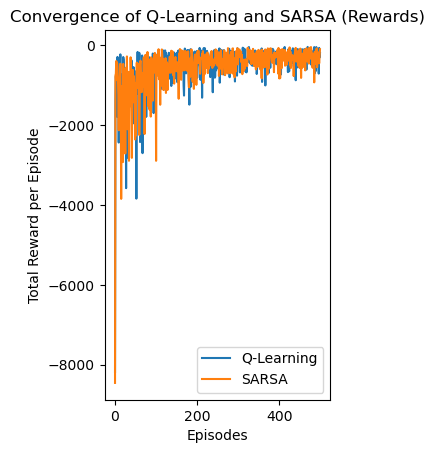

In [13]:
# Q-Learning and SARSA Rewards
plt.subplot(1, 2, 1)
plt.plot(q_learning_rewards, label="Q-Learning")
plt.plot(sarsa_rewards, label="SARSA")
plt.xlabel("Episodes")
plt.ylabel("Total Reward per Episode")
plt.title("Convergence of Q-Learning and SARSA (Rewards)")
plt.legend()

Text(0.5, 1.0, 'Convergence of Value Iteration (Delta)')

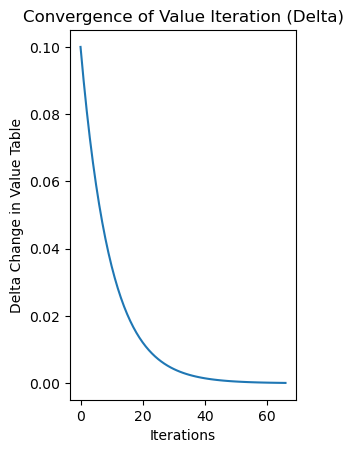

In [14]:
# Value Iteration Convergence
plt.subplot(1, 2, 2)
plt.plot(value_iteration_deltas)
plt.xlabel("Iterations")
plt.ylabel("Delta Change in Value Table")
plt.title("Convergence of Value Iteration (Delta)")

In [15]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>